In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.parser import parse 
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas.tseries.holiday as hol
from datetime import datetime as dt
import datetime
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Data Preparation and Feature Selection

In [2]:
us_cal = hol.USFederalHolidayCalendar()
dr = pd.date_range('2008-01-01',freq='1h', periods=43848)
us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())
us_holidays

DatetimeIndex(['2008-01-01', '2008-01-21', '2008-02-18', '2008-05-26',
               '2008-07-04', '2008-09-01', '2008-10-13', '2008-11-11',
               '2008-11-27', '2008-12-25', '2009-01-01', '2009-01-19',
               '2009-02-16', '2009-05-25', '2009-07-03', '2009-09-07',
               '2009-10-12', '2009-11-11', '2009-11-26', '2009-12-25',
               '2010-01-01', '2010-01-18', '2010-02-15', '2010-05-31',
               '2010-07-05', '2010-09-06', '2010-10-11', '2010-11-11',
               '2010-11-25', '2010-12-24', '2010-12-31', '2011-01-17',
               '2011-02-21', '2011-05-30', '2011-07-04', '2011-09-05',
               '2011-10-10', '2011-11-11', '2011-11-24', '2011-12-26',
               '2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12',
               '2012-11-22', '2012-12-25'],
              dtype='datetime64[ns]', freq=None)

In [3]:
eload = pd.read_excel('data2.xlsx')
eload=eload.drop(columns=['Predicted Load'])
eload.head()

,Date,Hour,Temperature,Load
0,2008-01-01,1,25.0,10737.0
1,2008-01-01,2,24.0,10348.0
2,2008-01-01,3,23.0,9997.0
3,2008-01-01,4,23.0,9760.0
4,2008-01-01,5,23.0,9624.0


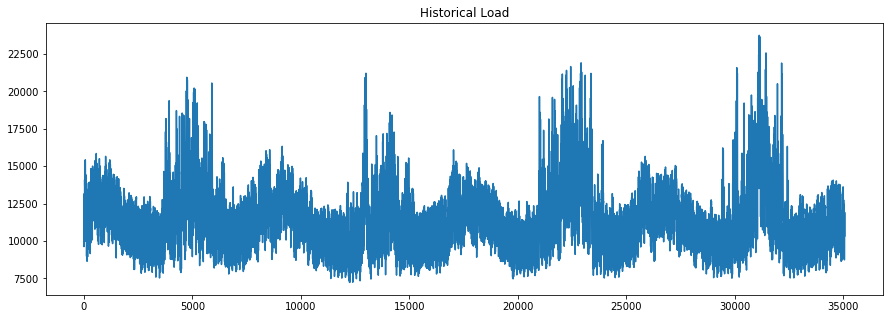

In [4]:
plt.figure(figsize=(15,5))
plt.plot(eload.Load)
plt.title('Historical Load')
plt.show()

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
series = pd.read_csv('autocorr.csv', index_col=0, header=0)
series.head()

,Load
Date,
1/1/2008,10737
1/1/2008,10348
1/1/2008,9997
1/1/2008,9760
1/1/2008,9624


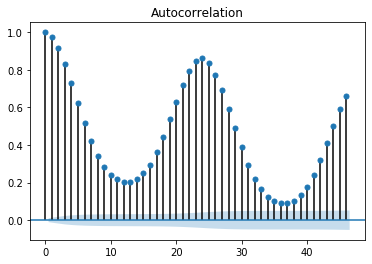

In [6]:
plot_acf(series)
plt.show()

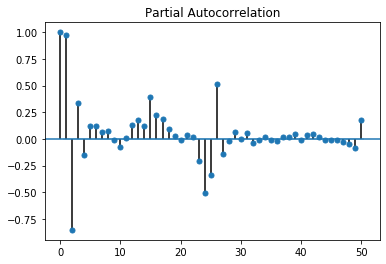

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=50)
plt.show()

In [8]:
eload['Hour']=eload['Hour']-1

In [9]:
eload['Hour1']=eload['Hour'].replace(1, datetime.time(1, 00)).replace(2, datetime.time(2, 00)).replace(3, datetime.time(3, 00)).replace(4, datetime.time(4, 00)).replace(5, datetime.time(5, 00)).replace(6, datetime.time(6, 00)).replace(7, datetime.time(7, 00)).replace(8, datetime.time(8, 00)).replace(9, datetime.time(9, 00)).replace(10, datetime.time(10, 00)).replace(11, datetime.time(11, 00)).replace(12, datetime.time(12, 00)).replace(13, datetime.time(13, 00)).replace(14, datetime.time(14, 00)).replace(15, datetime.time(15, 00)).replace(16, datetime.time(16, 00)).replace(17, datetime.time(17, 00)).replace(18, datetime.time(18, 00)).replace(19, datetime.time(19, 00)).replace(20, datetime.time(20, 00)).replace(21, datetime.time(21, 00)).replace(22, datetime.time(22, 00)).replace(23, datetime.time(23, 00)).replace(0, datetime.time(00, 00))

In [10]:
dts = [datetime.datetime.strptime(elem, '%Y-%m-%d%H:%M:%S') 
       for elem in eload['Date'].astype(str) + eload['Hour1'].astype(str)]

fmted = [elem.strftime('%Y-%m-%d %H:%M:%S') for elem in dts]

eload.insert(0, 'DateTime', fmted)

In [11]:
eload.tail()

,DateTime,Date,Hour,Temperature,Load,Hour1
43843,2012-12-31 19:00:00,2012-12-31,19,22.33,NaN,19:00:00
43844,2012-12-31 20:00:00,2012-12-31,20,20.67,NaN,20:00:00
43845,2012-12-31 21:00:00,2012-12-31,21,19.67,NaN,21:00:00
43846,2012-12-31 22:00:00,2012-12-31,22,19.33,NaN,22:00:00
43847,2012-12-31 23:00:00,2012-12-31,23,18.33,NaN,23:00:00


In [12]:
eload=eload.set_index('DateTime')
eload.head()

,Date,Hour,Temperature,Load,Hour1
DateTime,,,,,
2008-01-01 00:00:00,2008-01-01,0,25.0,10737.0,00:00:00
2008-01-01 01:00:00,2008-01-01,1,24.0,10348.0,01:00:00
2008-01-01 02:00:00,2008-01-01,2,23.0,9997.0,02:00:00
2008-01-01 03:00:00,2008-01-01,3,23.0,9760.0,03:00:00
2008-01-01 04:00:00,2008-01-01,4,23.0,9624.0,04:00:00


In [13]:
eload.index = pd.to_datetime(eload.index)

In [14]:
eload['holiday']=eload['Date'].isin(us_holidays).astype(np.int8)

In [15]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['Holiday'] = eload['holiday']
    df['temperature']=eload['Temperature']
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','holiday', 'temperature']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(eload, label='Load')
features_and_target = pd.concat([X, y], axis=1)

In [16]:
eload['Trend'] = np.arange(1,len(eload)+1)

In [17]:
dum_df = pd.get_dummies(features_and_target, columns=['hour', 'dayofweek', 'month', 'quarter'])

In [18]:
df_x = dum_df[[ 
        'hour_0','hour_1','hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23',
       'dayofweek_0', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6', 'quarter_1','quarter_2','quarter_3','quarter_4',
       'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'
        ]]

In [19]:
# data combination with necessary dummies and features
def create_features_1(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['holiday']=eload['holiday']
    df['temperature']=eload['Temperature']
    df['hour_0']=df_x['hour_0']
    df['hour_1']=df_x['hour_1']
    df['hour_2']=df_x['hour_2']
    df['hour_3']=df_x['hour_3']
    df['hour_4']=df_x['hour_4']
    df['hour_5']=df_x['hour_5']
    df['hour_6']=df_x['hour_6']
    df['hour_7']=df_x['hour_7']
    df['hour_8']=df_x['hour_8']
    df['hour_9']=df_x['hour_9']
    df['hour_10']=df_x['hour_10']
    df['hour_11']=df_x['hour_11']
    df['hour_12']=df_x['hour_12']
    df['hour_13']=df_x['hour_13']
    df['hour_14']=df_x['hour_14']
    df['hour_15']=df_x['hour_15']
    df['hour_16']=df_x['hour_16']
    df['hour_17']=df_x['hour_17']
    df['hour_18']=df_x['hour_18']
    df['hour_19']=df_x['hour_19']
    df['hour_20']=df_x['hour_20']
    df['hour_21']=df_x['hour_21']
    df['hour_22']=df_x['hour_22']
    df['hour_23']=df_x['hour_23']
    df['dayofweek_0']=df_x['dayofweek_0']
    df['dayofweek_1']=df_x['dayofweek_1']
    df['dayofweek_2']=df_x['dayofweek_2']
    df['dayofweek_3']=df_x['dayofweek_3']
    df['dayofweek_4']=df_x['dayofweek_4']
    df['dayofweek_5']=df_x['dayofweek_5']
    df['dayofweek_6']=df_x['dayofweek_6']
    df['month_1']=df_x['month_1']
    df['month_2']=df_x['month_2']
    df['month_3']=df_x['month_3']
    df['month_4']=df_x['month_4']
    df['month_5']=df_x['month_5']
    df['month_6']=df_x['month_6']
    df['month_7']=df_x['month_7']
    df['month_8']=df_x['month_8']
    df['month_9']=df_x['month_9']
    df['month_10']=df_x['month_10']
    df['month_11']=df_x['month_11']
    df['month_12']=df_x['month_12']
    df['quarter_1']=df_x['quarter_1']
    df['quarter_2']=df_x['quarter_2']
    df['quarter_3']=df_x['quarter_3']
    df['quarter_4']=df_x['quarter_4']
    df['lagload_hr'] = eload['Load'].shift(24)  
    df['lagload_week']=eload['Load'].shift(168)
    df['Trend']=eload['Trend']
    df['Temp_2']=eload['Temperature'].apply(lambda x:x*x)
    df['Temp_3']=eload['Temperature'].apply(lambda x:x*x*x)
    df['interaction_1']=eload['Hour']*df['dayofweek']
    df['interaction_2']=df['year']*df['quarter']
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','holiday', 'temperature',
           'hour_6', 'hour_7', 'hour_8','hour_1','hour_2','hour_3','hour_4','hour_5','hour_0',
           'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
           'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
           'hour_21', 'hour_22', 'hour_23','dayofweek_0', 'dayofweek_1',
           'dayofweek_2', 'dayofweek_3', 'dayofweek_4','dayofweek_5','dayofweek_6',
           'month_1', 'month_2', 'month_3',
            'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
           'month_10', 'month_11', 'month_12', 'quarter_1','quarter_2','quarter_3','quarter_4',
            'lagload_hr','lagload_week','Temp_2',
           'Temp_3', 'Trend','interaction_1','interaction_2']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features_1(eload, label='Load')
features_and_target_1 = pd.concat([X, y], axis=1)

In [20]:
features_and_target_1.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday,temperature,...,quarter_3,quarter_4,lagload_hr,lagload_week,Temp_2,Temp_3,Trend,interaction_1,interaction_2,Load
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,0,1,1,1,2008,1,1,1,1,25.0,...,0,0,NaN,NaN,625.0,15625.0,1,0,2008,10737.0
2008-01-01 01:00:00,1,1,1,1,2008,1,1,1,1,24.0,...,0,0,NaN,NaN,576.0,13824.0,2,1,2008,10348.0
2008-01-01 02:00:00,2,1,1,1,2008,1,1,1,1,23.0,...,0,0,NaN,NaN,529.0,12167.0,3,2,2008,9997.0
2008-01-01 03:00:00,3,1,1,1,2008,1,1,1,1,23.0,...,0,0,NaN,NaN,529.0,12167.0,4,3,2008,9760.0
2008-01-01 04:00:00,4,1,1,1,2008,1,1,1,1,23.0,...,0,0,NaN,NaN,529.0,12167.0,5,4,2008,9624.0


In [21]:
features_and_target_2=features_and_target_1.iloc[168:,:]

In [22]:
#Training and testing/validation set
split_date = '1-Jan-2011'
eload_train = features_and_target_2[features_and_target_2.index< split_date].copy()
eload_test = features_and_target_2[features_and_target_2.year==2011].copy()
eload_validation=features_and_target_2[features_and_target_2.year==2012].copy()

### M1. Prophet

In [23]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(eload_train.reset_index().rename(columns={'DateTime':'ds', 'Load':'y'}))

In [24]:
eload_train_fcst = model.predict(df=eload_train.reset_index().rename(columns={'DateTime':'ds'}))

In [25]:
mean_squared_error(y_true=eload_train['Load'],
                   y_pred=eload_train_fcst['yhat'])

1392040.8519279126

In [26]:
# MAPE in training set
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_train['Load'],
                   y_pred=eload_train_fcst['yhat'])

7.118785838306355

In [27]:
#Testing set
eload_test_fcst = model.predict(df=eload_test.reset_index().rename(columns={'DateTime':'ds'}))

In [28]:
mean_squared_error(y_true=eload_test['Load'],
                   y_pred=eload_test_fcst['yhat'])

2149922.9042111207

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_test['Load'],
                   y_pred=eload_test_fcst['yhat'])

9.294319357206657

## M2. Holt-Winter Smoothing

In [30]:
import statsmodels.api as sm

In [31]:
exp_smooth_train, exp_smooth_test = eload_train['Load'], eload_test['Load']

In [32]:
holt_winter = sm.tsa.ExponentialSmoothing(exp_smooth_train,seasonal_periods=24*365,seasonal='mul').fit()

In [33]:
y_hat_holt_winter = holt_winter.forecast(len(exp_smooth_train))
y_hat_holt_winter=y_hat_holt_winter.reset_index()
y_hat_holt_winter.columns = y_hat_holt_winter.columns.astype(str)
y_hat_holt_winter.columns.map(type)
y_hat_holt_winter=y_hat_holt_winter.rename(columns={'0':'yhat'})
y_hat_holt_winter.count()

index    26136
yhat     26136
dtype: int64

In [34]:
mean_squared_error(y_true=eload_train['Load'],
                   y_pred=y_hat_holt_winter['yhat'])

4891648.55140227

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_train['Load'],
                   y_pred=y_hat_holt_winter['yhat'])

14.122380962875425

In [36]:
y_hat_holt_winter_test = holt_winter.forecast(len(exp_smooth_test))
y_hat_holt_winter_test=y_hat_holt_winter_test.reset_index()
y_hat_holt_winter_test.columns = y_hat_holt_winter_test.columns.astype(str)
y_hat_holt_winter_test.columns.map(type)
y_hat_holt_winter_test=y_hat_holt_winter_test.rename(columns={'0':'yhat'})
y_hat_holt_winter_test.count()

index    8760
yhat     8760
dtype: int64

In [37]:
mean_squared_error(y_true=eload_test['Load'],
                   y_pred=y_hat_holt_winter_test['yhat'])

5602885.29818063

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_test['Load'],
                   y_pred=y_hat_holt_winter_test['yhat'])

14.623278795283282

### M4. SARIMAX

In [39]:
eload.head()

,Date,Hour,Temperature,Load,Hour1,holiday,Trend
DateTime,,,,,,,
2008-01-01 00:00:00,2008-01-01,0,25.0,10737.0,00:00:00,1,1
2008-01-01 01:00:00,2008-01-01,1,24.0,10348.0,01:00:00,1,2
2008-01-01 02:00:00,2008-01-01,2,23.0,9997.0,02:00:00,1,3
2008-01-01 03:00:00,2008-01-01,3,23.0,9760.0,03:00:00,1,4
2008-01-01 04:00:00,2008-01-01,4,23.0,9624.0,04:00:00,1,5


In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [41]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [42]:
from pmdarima.arima import auto_arima

In [43]:
step_wise=auto_arima(eload_train.Load,start_p=1,start_q=1, max_p=7,max_q=7,trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=362727.246, BIC=362759.930, Fit time=12.890 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=398377.089, BIC=398393.431, Fit time=0.841 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=367828.612, BIC=367853.126, Fit time=2.445 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=375307.895, BIC=375332.408, Fit time=9.329 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=398375.089, BIC=398383.260, Fit time=0.373 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=362413.787, BIC=362454.642, Fit time=7.824 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=362737.449, BIC=362770.133, Fit time=3.930 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=362391.151, BIC=362440.177, Fit time=11.876 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=362577.417, BIC=362618.272, Fit time=5.926 seconds

In [44]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                26136
Model:               SARIMAX(5, 1, 2)   Log Likelihood             -179243.153
Date:                Mon, 16 Dec 2019   AIC                         358504.307
Time:                        09:45:55   BIC                         358577.846
Sample:                             0   HQIC                        358528.059
                              - 26136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0509      0.206      0.248      0.804      -0.352       0.454
ar.L1          1.0414      0.006    178.415      0.000       1.030       1.053
ar.L2          0.4323      0.008     52.362      0.000       0.416       0.448
ar.L3         -0.8657      0.007   -116.288      0.000      -0.880      -0.851
ar.L4          0.4780      0.008     59.998      0.000       0.462       0.494
ar.L5         -0.2545      0.007    -38.376      0.000      -0.267      -0.241
ma.L1          0.0537      0.003     16.270      0.000       0.047       0.060
ma.L2         -0.9339      0.003   -282.758      0.000      -0.940      -0.927
sigma2      5.626e+04    400.321    140.531      0.000    5.55e+04     5.7e+04
===================================================================================
Ljung-Box (Q):                    23104.43   Jarque-Bera (JB):              5342.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.09
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
model=SARIMAX(eload_train.Load,order=(5,1,2), enforce_invertibility=False, enforce_stationarity=False)

In [47]:
results=model.fit()

In [48]:
train_size=int(len(eload_train))
test_size=int(len(eload_test))
test_size

8760

In [49]:
predictions=results.predict(start=0, end=train_size)

In [50]:
predictions=pd.DataFrame(predictions)
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions['Actual']=eload_train['Load']
predictions=predictions.dropna()

In [51]:
mean_absolute_error(y_true=predictions['Actual'],
                   y_pred=predictions['Pred'])

164.8731970790767

In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=predictions['Actual'],
                   y_pred=predictions['Pred'])

1.4106373846610347

In [53]:
predictions_1=results.predict(start=26305, end=35064)

In [54]:
predictions_1=pd.DataFrame(predictions_1)
predictions_1.rename(columns={0:'Pred'}, inplace=True)
predictions_1['Actual']=eload_test['Load']
predictions_1=predictions_1.dropna()

In [55]:
mean_absolute_error(y_true=predictions_1['Actual'],
                   y_pred=predictions_1['Pred'])

1976.5400747216531

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=predictions_1['Actual'],
                   y_pred=predictions_1['Pred'])

15.458279154038157

### M5. Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
X_train, y_train = create_features_1(eload_train), eload_train['Load']
X_test, y_test   = create_features_1(eload_test), eload_test['Load']
X_train=X_train.fillna(0)

In [59]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions = linear_regressor.predict(X_train)

In [60]:
def get_Mape(y_train, y_pred):
    return np.mean(np.abs((y_train - y_pred) / y_train)) * 100

In [61]:
get_Mape(y_train, predictions)

4.011031573161104

In [62]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_test, y_test)
predictions_1 = linear_regressor.predict(X_test)

In [63]:
def get_Mape(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [64]:
get_Mape(y_test, predictions_1)

4.152119967077528

### M6. Ridge

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV,LassoLarsCV
from sklearn.linear_model import LinearRegression, Ridge

scaler = StandardScaler()

In [66]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3) 

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=5)
parameters={'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='mean_absolute_percentage_error', cv=5)

In [69]:
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [70]:
ridge.score(X_train, y_train)

0.9228349734822602

In [71]:
prediction=ridge.predict(X_train)

In [72]:
mean_absolute_error(y_true=eload_train['Load'],
                   y_pred=predictions)

466.5220786120091

In [73]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_train['Load'],
                   y_pred=predictions)

4.011031573161114

In [74]:
prediction_1=ridge.predict(X_test)

In [75]:
mean_absolute_error(y_true=eload_test['Load'],
                   y_pred=predictions_1)

489.19346994069025

In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_test['Load'],
                   y_pred=predictions_1)

4.152119967077531

### M7. Lasso

In [77]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [78]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef.head()

hour          86.174825
dayofweek   -158.094836
quarter       -0.000000
month         -0.000000
year           0.000000
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

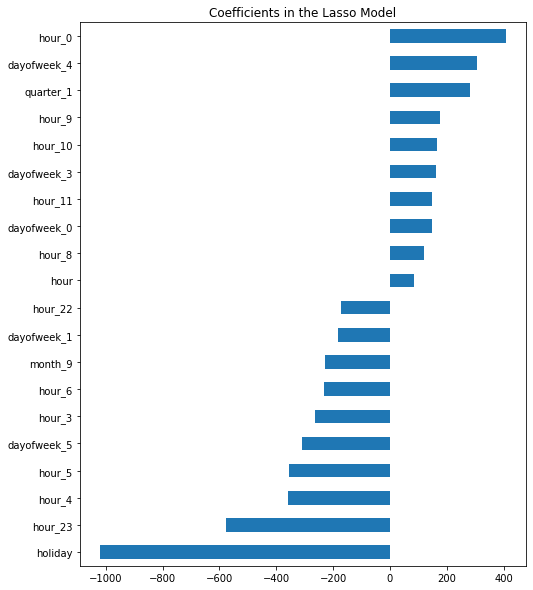

In [79]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [80]:
model_lasso.fit(X_train,y_train)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv='warn', eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [81]:
prediction=model_lasso.predict(X_train)

In [82]:
mean_absolute_error(y_true=eload_train['Load'],
                   y_pred=prediction)

468.3255961715969

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_train['Load'],
                   y_pred=prediction)

4.019136608560457

In [84]:
prediction_1=model_lasso.predict(X_test)

In [85]:
mean_absolute_error(y_true=eload_test['Load'],
                   y_pred=prediction_1)

503.8995767805435

In [86]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=eload_test['Load'],
                   y_pred=prediction_1)

4.253386935177255